### Loading Libraries

In [38]:
#Importing libraries required to load the data

import zipfile
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, LeakyReLU, GlobalAvgPool2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping

#to ignore warnings
import warnings
warnings.filterwarnings('ignore')

#to ignore warnings
import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

### Importing Data

In [8]:
# Import data

path = 'cell_images.zip'
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall()

### Splitting Data

In [9]:
#Storing the path of the extracted "train" folder 
train_dir = '/cell_images/train'

#Size of image so that each image has the same size
SIZE = 64

#Empty list to store the training images after they are converted to NumPy arrays
train_images = []

#Empty list to store the training labels (0 - uninfected, 1 - parasitized)
train_labels = []

In [11]:
#We will run the same code for "parasitized" as well as "uninfected" folders within the "train" folder
for folder_name in ['/parasitized/', '/uninfected/']:
    
    #Path of the folder
    images_path = os.listdir("C:/Users/Jules/Documents/Malaria-Detection" + train_dir + folder_name)

    for i, image_name in enumerate(images_path):
        try:
            #Opening each image using the path of that image
            image = Image.open("C:/Users/Jules/Documents/Malaria-Detection" + train_dir + folder_name + image_name)

            #Resizing each image to (224,224)
            image = image.resize((SIZE, SIZE))

            #Converting images to arrays and appending that array to the empty list defined above
            train_images.append(np.array(image))

            #Creating labels for parasitized and uninfected images
            if folder_name=='/parasitized/':
                train_labels.append(1)
            else:
                train_labels.append(0)
        except Exception:
            pass       

#Converting lists to arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [12]:
#Storing the path of the extracted "test" folder 
test_dir = '/cell_images/test'

#Size of image so that each image has the same size (it must be same as the train image size)
SIZE = 64

#Empty list to store the testing images after they are converted to NumPy arrays
test_images = []

#Empty list to store the testing labels (0 - uninfected, 1 - parasitized)
test_labels = []

In [13]:
#We will run the same code for "parasitized" as well as "uninfected" folders within the "test" folder
for folder_name in ['/parasitized/', '/uninfected/']:
    
    #Path of the folder
    images_path = os.listdir("C:/Users/Jules/Documents/Malaria-Detection" + test_dir + folder_name)

    for i, image_name in enumerate(images_path):
        try:
            #Opening each image using the path of that image
            image = Image.open("C:/Users/Jules/Documents/Malaria-Detection" + test_dir + folder_name + image_name)
            
            #Resizing each image to (128,128)
            image = image.resize((SIZE, SIZE))
            
            #Converting images to arrays and appending that array to the empty list defined above
            test_images.append(np.array(image))
            
            #Creating labels for parasitized and uninfected images
            if folder_name=='/parasitized/':
                test_labels.append(1)
            else:
                test_labels.append(0)
        except Exception:
            pass       

#Converting lists to arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

### Data Exploration

In [15]:
# Shape of data
print('Training set:', train_images.shape)
print('Test set:', test_images.shape)
print('Training label:', train_labels.shape)
print('Test label:', test_labels.shape)

Training set: (24958, 64, 64, 3)
Test set: (2600, 64, 64, 3)
Training label: (24958,)
Test label: (2600,)


In [16]:
# Normalizing Dataset
train_images = (train_images/255).astype('float32')
test_images = (test_images/255).astype('float32')

In [17]:
# Encoding Train Labels
train_labels=to_categorical(train_labels,2)
# Encoding test labels
test_labels=to_categorical(test_labels,2)

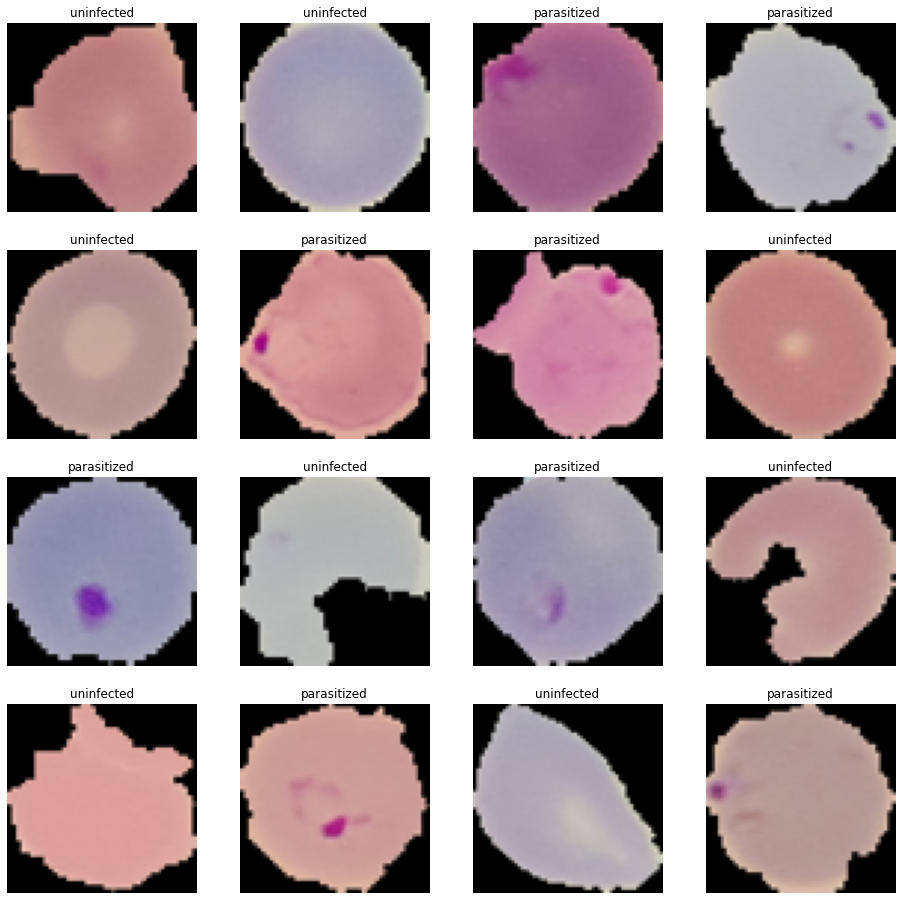

In [27]:
# Visualizing Images
np.random.seed(42)
plt.figure(1 , figsize = (16 , 16))

for n in range(1, 17):
    plt.subplot(4, 4, n)
    index = int(np.random.randint(0, train_images.shape[0], 1))
    if train_labels[index][1] == 1: 
        plt.title('parasitized')
    else:
        plt.title('uninfected')
    plt.imshow((train_images[index] * 255).astype(np.uint8))
    plt.axis('off')

### Building Model

In [28]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [33]:
# Adding Layers
model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=(64, 64, 3), padding='same', activation="relu"))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(512,activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(2,activation="softmax"))

adam = optimizers.Adam(learning_rate=0.001)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 32, 32, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 32)       

In [34]:
# Compiling model
model.compile(loss="binary_crossentropy", optimizer=adam, metrics = ['accuracy'])

In [39]:
# Creating callbacks
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]